## Tools Setup

In [1]:
import pathlib, os, sys, operator, re, datetime
from functools import reduce
import numpy as np
import tensorflow as tf
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import Model
from keras import models
import tensorflow_datasets as tfds
from tiny_imagenet import TinyImagenetDataset

# Enable or disable GPU
# To fully disable it, we need to hide all GPU devices from Tensorflow
# Make sure GPU is disabled for this inference part of the lab
ENABLE_GPU = True
# tf.debugging.set_log_device_placement(True)

if not ENABLE_GPU:
    tf.config.set_visible_devices([], 'GPU')

# Print Python and TF version, and where we are running
print(f'Running on Python Version: {sys.version}')
print(f'Using Tensorflow Version: {tf. __version__}')
if not tf.config.experimental.list_physical_devices("GPU"):
    print('Running on CPU')
else:
    print(f'Using GPU at: {tf.test.gpu_device_name()} (of {len(tf.config.experimental.list_physical_devices("GPU"))} available)')

2024-12-09 15:11:00.954578: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733778660.966813   24336 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733778660.970596   24336 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-09 15:11:00.984474: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Running on Python Version: 3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]
Using Tensorflow Version: 2.18.0
Using GPU at: /device:GPU:0 (of 1 available)


I0000 00:00:1733778662.672559   24336 gpu_device.cc:2022] Created device /device:GPU:0 with 21674 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:0b:00.0, compute capability: 8.6


## Dataset Inspection

In [2]:
# This cell imports our dataset.

# Original Source: https://github.com/ksachdeva/tiny-imagenet-tfds
# Class Version Source: https://github.com/duweisu/tiny-imagenet-tfds
# Setup our dataset
# ---------------------------------------------------------

tiny_imagenet_builder = TinyImagenetDataset()

# this call (download_and_prepare) will trigger the download of the dataset
# and preparation (conversion to tfrecords)
#
# This will be done only once and on next usage tfds will
# use the cached version on your host.
tiny_imagenet_builder.download_and_prepare(download_dir="~/tensorflow-datasets/downloads")

# class_names = tiny_imagenet_builder.info.features['label'].names
ds = tiny_imagenet_builder.as_dataset()
ds_train, ds_val = ds["train"], ds["validation"]
assert(isinstance(ds_train, tf.data.Dataset))
assert(isinstance(ds_val, tf.data.Dataset))

# Training Dataset
ds_train = ds_train.shuffle(1024).prefetch(tf.data.AUTOTUNE)

# Validation Dataset
ds_val = ds_val.shuffle(1024).prefetch(tf.data.AUTOTUNE)

# Dataset metadata
ds_info = tiny_imagenet_builder.info

2024-12-09 15:11:02.684994: W external/local_tsl/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


/home/alex/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Dl Completed...: 100%|██████████| 1/1 [00:00<00:00, 127.79 url/s]
Extraction completed...: 0 file [00:00, ? file/s]
I0000 00:00:1733778677.524133   24336 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21674 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:0b:00.0, compute capability: 8.6


Dataset tiny_imagenet_dataset downloaded and prepared to /home/alex/tensorflow_datasets/tiny_imagenet_dataset/0.2.0. Subsequent calls will reuse this data.


In [3]:
# We need to read the "human readable" labels so we can translate with the numeric values
# Read the labels file (words.txt)
with open(os.path.abspath('wnids.txt'), 'r') as f:
    wnids = [x.strip() for x in f]

# Map wnids to integer labels
wnid_to_label = {wnid: i for i, wnid in enumerate(wnids)}
label_to_wnid = {v: k for k, v in wnid_to_label.items()}

# Use words.txt to get names for each class
with open(os.path.abspath('words.txt'), 'r') as f:
    wnid_to_words = dict(line.split('\t') for line in f)
    for wnid, words in wnid_to_words.items():
        wnid_to_words[wnid] = [w.strip() for w in words.split(',')]
        
class_names = [str(wnid_to_words[wnid]) for wnid in wnids]

In [4]:
# Helper function to get the label name
def img_class(img_data, idx=None):
    image, label, id, label_name = img_data["image"], img_data["label"], img_data["id"], img_data["metadata"]['label_name']
    # Handle batches of images correctly
    if idx != None:
        image, label, id, label_name = img_data["image"][idx], img_data["label"][idx], img_data["id"][idx], img_data["metadata"]['label_name'][idx]
    
    return f"{label_name} (class index: {label} - id: {id})"


# Helper function to show basic info about an image
def img_info(img, idx=None, display=True, title_apend=""):
    image = img['image']

    # Print the class
    class_str = img_class(img, idx)
    print(f"Label: {class_str}")
    
    # Display the image
    if display:
        plt.figure()
        plt.title(title_apend + class_str)
        # Handle batches correctly
        if image.shape.ndims > 3:
            plt.imshow(image.numpy().reshape(64, 64, 3))
        else:
            plt.imshow(image.numpy())

--- Train & Validation dataset info ---
Train: <_PrefetchDataset element_spec={'id': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'metadata': {'label_name': TensorSpec(shape=(), dtype=tf.string, name=None)}}>
Validation: <_PrefetchDataset element_spec={'id': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'metadata': {'label_name': TensorSpec(shape=(), dtype=tf.string, name=None)}}>

--- Show an example image ---
Label: b'dumbbell' (class index: 154 - id: b'n03255030')

 Show some other examples


2024-12-09 15:11:18.095659: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:376] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2024-12-09 15:11:18.112628: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-12-09 15:11:18.128375: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-09 15:11:18.181978: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached conte

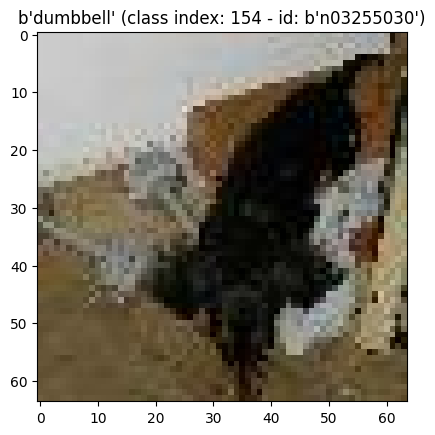

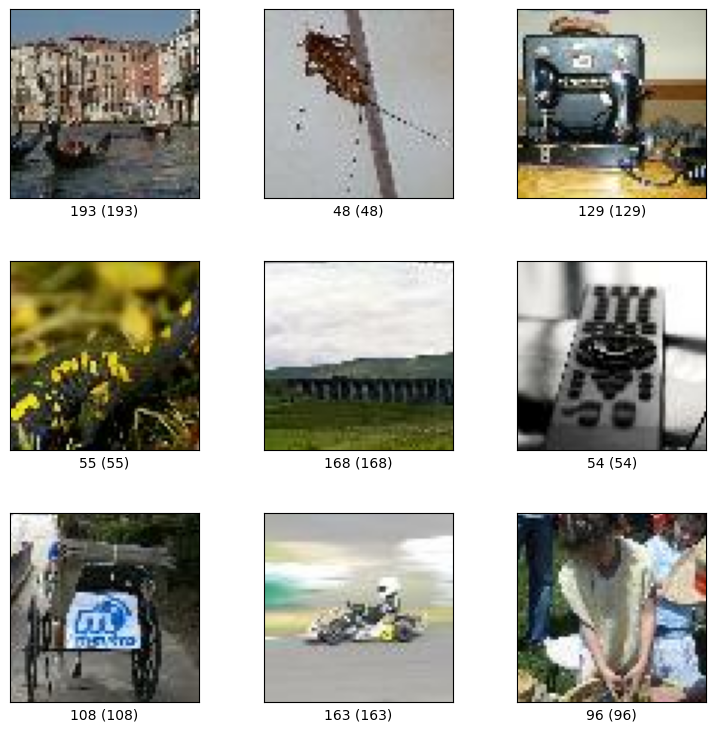

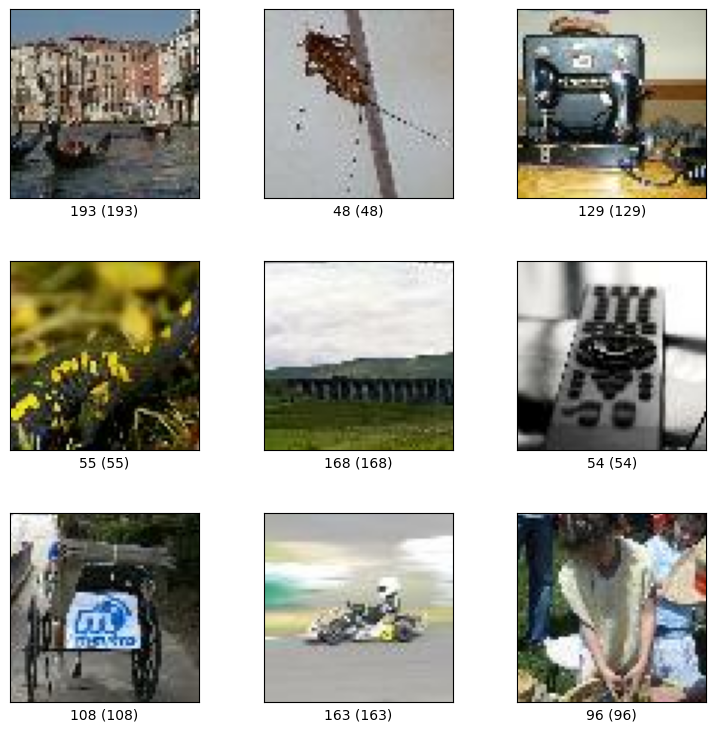

In [5]:
# Print the dataset types and info
print("--- Train & Validation dataset info ---")
print(f"Train: {ds_train}")
print(f"Validation: {ds_val}")
# print(f"Dataset Info: {ds_info}") # Uncomment to print Dataset info

print("\n--- Show an example image ---")
for example in ds_val.take(1):
    img_info(example)

print("\n Show some other examples")
tfds.show_examples(ds_val, ds_info, rows=3, cols=3)


--- Image 0 ---
Label: b'limousine, limo' (class index: 114 - id: b'n03670208')
Label - 114
Id - b'n03670208'
Label Name - b'limousine, limo'
Data Type - <dtype: 'uint8'>
Dimensions - (64, 64, 3)
Memory - 98.304 KB

--- Image 1 ---
Label: b'Egyptian cat' (class index: 0 - id: b'n02124075')
Label - 0
Id - b'n02124075'
Label Name - b'Egyptian cat'
Data Type - <dtype: 'uint8'>
Dimensions - (64, 64, 3)
Memory - 98.304 KB

--- Image 2 ---
Label: b'Persian cat' (class index: 131 - id: b'n02123394')
Label - 131
Id - b'n02123394'
Label Name - b'Persian cat'
Data Type - <dtype: 'uint8'>
Dimensions - (64, 64, 3)
Memory - 98.304 KB


2024-12-09 15:11:18.713960: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


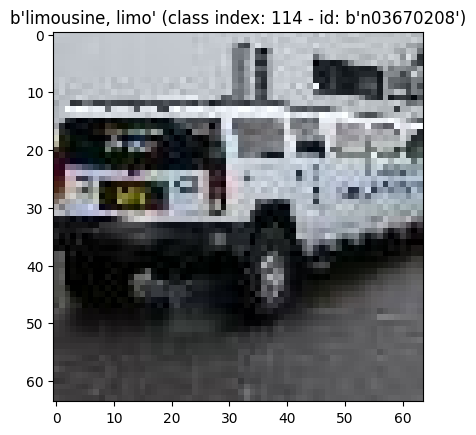

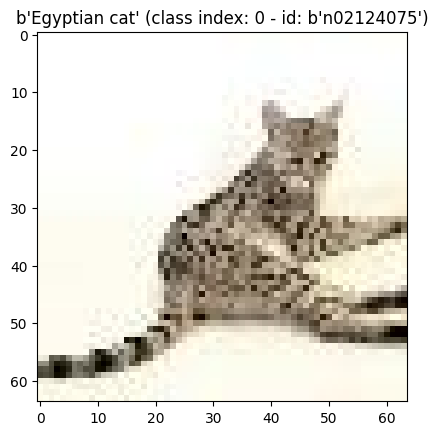

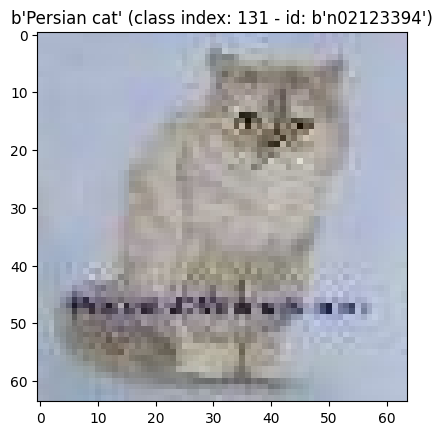

In [6]:
# Select 3 images from the data set and print some information about them

# Sample Images
sample_imgs = []
for index, img_data in enumerate(ds_val.take(3)):
    sample_imgs.append(img_data)
    image, label, id, label_name = img_data["image"], img_data["label"], img_data["id"], img_data["metadata"]['label_name']

    print(f'\n--- Image {index} ---')
    # See example usage: https://github.com/duweisu/tiny-imagenet-tfds
    img_info(img_data)
    print(f"Label - {label.numpy()}")
    print(f"Id - {id.numpy()}")
    print(f"Label Name - {label_name}")
    print(f"Data Type - {image.dtype}")
    print(f"Dimensions - {image.shape}")

    # Calculate size in memory, assume RGB uses uint8
    print(f"Memory - {image.shape[0] * image.shape[1] * image.shape[2] * 8 / 1000} KB")

In [7]:
# Export each of the three inputs to a binary file which will be used to load the images into C++ later

# Make a directory for our image data
img_dir = os.path.abspath('img_data')
pathlib.Path(img_dir).mkdir(exist_ok=True)

# Create a metadata file
metadata_file = open(os.path.join(img_dir, f'metadata.txt'), 'w')
metadata_file.write(f'Number\t\tDims\t\tClass Data\n')

# Export each image
for index, img_data in enumerate(sample_imgs):
    image = img_data["image"] 
    metadata_file.write(f'{index}\t\t{image.shape}\t\t{img_class(img_data=img_data)}\n')

    img_file = open(os.path.join(img_dir, f'image_{index}.bin'), 'wb')

    img_flat_array = image.numpy().flatten() # Convert Tensor to numpy array and flatten the array (ex: 4D --> 1D). So 64*64*3 = 12288 element 1D array
    img_file.write(img_flat_array)

    img_file.close()

metadata_file.close()

## Model Loading and Inference

In [ ]:
# Load the model
# Now we will load the H5 model! Please make sure the h5 model file is present in the below directory.
# You can download this from the Canvas Page and place it in the same directory as this notebook.

# model_path = os.path.abspath(""/home/<NETID>/path/to/your/lab1/CNN_TinyImageNet_2.h5)" # Uncomment this to use a non-relative path
model_path = os.path.abspath("CNN_TinyImageNet_2.h5")

model = tf.keras.models.load_model(model_path)

/home/alex/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


ValueError: Kernel shape must have the same length as input, but received kernel of shape (5, 5, 3, 32) and input of shape (None, None, 64, 64, 3).

In [ ]:
# Running infrence on our model
# We can run an infrence of our model by doing the following (we are doing batches of 1 here)
for example in ds_train.batch(1).take(1):
    img_info(example)
    
    # Make a prediction
    pred = model.predict(tf.cast(example["image"], tf.float32)/255.0)
    # print(f'Raw 200 Class Weighted Prediction:\n{pred}') # Uncomment to see the raw prediction
    
    # What is out best guess?
    best_guess = tf.math.argmax(pred, axis=1).numpy() # Our output is 200 weighted value, we want the most likely
    print(f'Best Guess [class index]: {class_names[best_guess[0]]} [{best_guess[0]}]')
    print(f'Best Guess Confidence (percent / 1.0): {pred[0][best_guess]}')

    # What are our top 15 guesses?
    top_15 = tf.math.top_k(pred, k=15)
    print(f'Top 15 Guesses (class index): {[f"{class_names[idx]} [{idx}]" for idx in top_15.indices[0]]}')
    print(f'Top 15 Guesses Confidence (percent / 1.0): {top_15.values}')

In [ ]:
# Run infrence for our previous 3 sample images

# array of predicted class for each sample image
pred = []

for index, image in enumerate(sample_imgs):

    pred.append(model.predict(tf.cast(tf.expand_dims(image["image"], axis=0), tf.float32)/255.0))
    # print(f'Raw 200 Class Weighted Prediction:\n{pred}') # Uncomment to see the raw prediction

    # What is our best guess?
    best_guess = tf.math.argmax(pred[index], axis=1).numpy() # Our output is 200 weighted value, we want the most likely
    print(f'Best Guess [class index]: {class_names[best_guess[0]]} [{best_guess[0]}]')
    print(f'Best Guess Confidence (percent / 1.0): {pred[index][0][best_guess]}')
    print(f'Actual class: {image["label"]}')

    # What are our top 15 guesses?
    top_15 = tf.math.top_k(pred[index], k=15)
    print(f'Top 15 Guesses (class index): {[f"{class_names[idx]} [{idx}]" for idx in top_15.indices[0]]}')
    print(f'Top 15 Guesses Confidence (percent / 1.0): {top_15.values}\n')

In [ ]:
# Calculate the Top-1, Top-5, and Top-10 Accuracy of the validation dataset
total = acc_top1 = acc_top5 = acc_top10 = 0

for batch in ds_val.batch(32):
  top_preds = model.predict(tf.cast(batch["image"], tf.float32) / 255.0)
  top_10 = tf.math.top_k(top_preds, k=10).indices
  top_5 = tf.math.top_k(top_preds, k=5).indices
  top_1 = tf.math.top_k(top_preds, k=1).indices

  for idx, img_label in enumerate(batch["label"].numpy()):
    if img_label in top_10[idx]:
      acc_top10 += 1
    if img_label in top_5[idx]:
      acc_top5 += 1
    if img_label in top_1[idx]:
      acc_top1 += 1
  
  total += 32


print(f'Top1 Accuracy {acc_top1 / total}')
print(f'Top5 Accuracy {acc_top5 / total}')
print(f'Top10 Accuracy {acc_top10 / total}')

In [ ]:
# Print all of the possible classes of the dataset

def get_classes(dataset):
    classes = set()

    for index, img_data in enumerate(dataset):
        label = img_data['label']
        classes.add(label.numpy())

    for label in classes:
        print(f"Class ID: {label}, Class Name: {class_names[label]}")


print(f"\nClasses in Training Dataset")
get_classes(ds_train)
print(f"\nClasses in Validation Dataset")
get_classes(ds_val)
    

There are 200 classes in each split of the dataset. There are 500 images for each class, resulting in 100000 total data points. It's important to have a lot of data points so the model can properly generalize the properties of objects, and not just pick up on the specific details of the images in the training set. 

## Model Exploration

In [ ]:
# Visualize the model in Netron and include an image here.
#tf.keras.utils.plot_model(model, "model.png", show_shapes=True, show_dtype=True, expand_nested=True)
print(model.summary())

In [ ]:
# We can view the layer weights. Here we consider them as images of feature filters applied to intermediate feature map images.
# Visualize the 2 convolutional layers filter sets (weights) (one at the beginning and one at the end

begin_layer = model.get_layer('conv2d')
weights = begin_layer.get_weights()[0]

num_filters = weights.shape[-1]
plt.figure(figsize=(20, 20))
for i in range(num_filters):
  ax = plt.subplot(8, 8, i + 1)
  plt.imshow(weights[:, :, 0, i], cmap='viridis') # Use red in RGB for now
plt.show()

end_layer = model.get_layer('conv2d_5')
weights = end_layer.get_weights()[0]

num_filters = weights.shape[-1]
plt.figure(figsize=(20, 20))
for i in range(num_filters):
  ax = plt.subplot(10, 13, i + 1)
  plt.imshow(weights[:, :, 0, i], cmap='viridis') # Use channel 1 for now
plt.show()

# We also wrote the process to visualize the dense layer in addition
# last_layer = model.get_layer('dense_1')
# weights, biases = last_layer.get_weights()

# plt.figure(figsize=(10, 8))
# plt.imshow(weights, cmap='viridis', aspect='auto')
# plt.colorbar()
# plt.show()

The filters' data type is float32. Running the above code will output two plots containing the weights of red channel of the first convolutional layer, and the last dense layer. It can be seen that the first convolutional layer has 32 5x5 filters that are passed over the input feature map. Each filter has weights for each color channel. Additionally, the last layer only has one filter matrix, and the plot shows the weights of the red channel as well. 

The memory required to store weights of the first layer with all color channels is: 5 wide x 5 high x 3 color channels deep x 32 bits per pixel x 32 filters = 76800 bits = 9.6 KB

The memory required to store the weights of the last layer with all color channels is: 3 wide x 3 high x 64 channels x 32 bits per pixel x 128 filters = 294.9 KB

In [ ]:
# We can view the layer outputs as well. Here we consider them as images of the spatial location of features.
# Visualize the 2 convolutional layers outputs (intermediate feature maps) (one at the beginning and one at the end)

layer_outputs = [layer.output for layer in model.layers]
activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input

activations = []

first_layer_cfg = model.get_layer('conv2d').get_config()
print(first_layer_cfg)

end_layer_cfg = model.get_layer('conv2d_5').get_config()
print(end_layer_cfg)

# Run inference on each sample image using the new activation model
for index, image in enumerate(sample_imgs):
    activations.append(activation_model.predict(tf.cast(tf.expand_dims(image["image"], axis=0), tf.float32)/255.0)) # Returns a list of five Numpy arrays: one array per layer activation

first_layer_act = activations[0][0]
plt.matshow(first_layer_act[0, :, :, 1], cmap='viridis')

last_layer_act = activations[0][5]
plt.matshow(last_layer_act[0, :, :, 1], cmap='viridis')

The activations' data type is float32. The memory required to store weights of the activation of the first convolutional layer with all color channels is: 64 wide x 64 high x 3 color channels deep x 32 bits per pixel =  bits = 49.2 KB. The memory required to store the weights of the activation of the last convolutional layer  with all color channels is: 12 wide x 12 high x 3 channels x 32 bits per pixel = 13.8 KB

The input feature map becomes increasingly simplified (decreased resolution) as it passes through each Conv2D layer. The deeper convolution layers have more channels in their filters than the shallower ones, however The number of channels present in the activation output does not change.

Regarding the correlation between kernel and layer number in the model, the deeper layers have kernels with a smaller width and height than the upper layers. However, the number of channels present in each kernel increases with depth in the model. Additionally, as you progress deeper into the layers, the features that are being abstracted from the input feature map become increasingly simplified. You can see that the 1st layer activation retains the general shape of the image, whereas the last convolutional layer is considerably more abstract.

In [ ]:
# Make a directory for our image data
model_dir = os.path.abspath('model_data')
pathlib.Path(model_dir).mkdir(exist_ok=True)

# Export each image
conv_index = dense_index = 1 # layer index starts from one
for layer_idx, layer in enumerate(model.layers):
    if re.match(r'(conv|dense)', layer.name):
        weight_file_name = os.path.join(model_dir, f'{layer.name}_weights.bin')
        bias_file_name = os.path.join(model_dir, f'{layer.name}_biases.bin')
    else: continue

    assert layer.weights[0].name.endswith('kernel:0')
    assert layer.weights[1].name.endswith('bias:0')
        
    # print(layer.weights[0])
    # print(layer.weights[1])
    weight_file = open(weight_file_name, 'wb')
    bias_file = open(bias_file_name, 'wb')

    weights_flat = layer.weights[0].numpy().flatten() 
    weight_file.write(weights_flat)

    bias_flat = layer.weights[1].numpy().flatten()
    bias_file.write(bias_flat)

    weight_file.close()
    bias_file.close()

In [ ]:
# Export the intermediate layer outputs for each of the input for all of the layers
img_dir = os.path.abspath('img_data')
pathlib.Path(img_dir).mkdir(exist_ok=True)

for img_idx, img in enumerate(sample_imgs):
    file_dir = os.path.join(img_dir, f'test_input_{img_idx}')
    pathlib.Path(file_dir).mkdir(exist_ok=True)
    
    #We already grabbed the activations for the three sample images in a previous cell
    #For each layer activation in the current image, generate a binary
    # print(activations[img_idx][0])

    for layer_idx, layer in enumerate(model.layers):
        # print(activations[img_idx][layer_idx])
        activation_file_name = os.path.join(file_dir, f'{layer.name}_activation.bin')
        activation_file = open(activation_file_name, 'wb')

        activation_flat = activations[img_idx][layer_idx].flatten()
        activation_file.write(activation_flat)

        activation_file.close()

## Tensorboard

In [ ]:
# Setup for profiling
tf.profiler.experimental.ProfilerOptions(
    host_tracer_level=1, python_tracer_level=0, device_tracer_level=1
)

log_dir = os.path.abspath(os.path.join('log_data'))
log_dir_run = os.path.abspath(os.path.join(log_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))
pathlib.Path(log_dir_run).mkdir(exist_ok=True, parents=True)

try:
    tf.profiler.experimental.stop()
except:
    test = 2
finally:
    test = 1

In [ ]:
# Sample Profiling - Inference for a single image:

# Perform the inference profiling (example):
# for example in ds_train.batch(1).take(1):
#     # Starts Profile logging
#     tf.profiler.experimental.start(os.path.join(log_dir_run, f'single-{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}'))

#     # Actual inference
#     model.predict(tf.cast(example["image"], tf.float32)/255.0)

#     tf.profiler.experimental.stop()

# Perform inference profiling on 3 sample images from validation
i = 0
for image in sample_imgs:
    # Starts Profile logging
    tf.profiler.experimental.start(os.path.join(log_dir_run, f'single-{i}-{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}'))

    # Actual inference
    model.predict(tf.cast(tf.expand_dims(image["image"], axis=0), tf.float32)/255.0)

    tf.profiler.experimental.stop()
    i += 1

In [ ]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

# Launch TensorBoard and navigate to the Profile tab to view performance profile. 
# *** Please note just execute this command once in a session and 
# then logs for subsequent runs would be auto detected in tensorboard- url: http://localhost:6006/
print(log_dir)
%tensorboard --logdir={log_dir} --port=6006

# You can view the tensorboard in the browser url: http://localhost:6006/

# Useful command line to have if tensorboard is misbehaving: kill $(ps -e | grep 'tensorboard' | awk '{print $1}')

In [ ]:
# Sample Profiling - Online Inference:

# Vary this from 10, 100, 1000 to simulate multiple online inference
loop_index = [10, 100, 1000]

for idx in loop_index:
    # Starts Profile logging
    tf.profiler.experimental.start(os.path.join(log_dir, f'online-infrence-{idx}-{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}'))

    # Actual online inference
    for example in ds_train.batch(1).take(idx):
        model.predict(tf.cast(example["image"], tf.float32)/255.0)
    
    tf.profiler.experimental.stop()

In [ ]:
# Sample Profiling - Batch Inference:

# We would only perform batch inference for a subset of validation set i.e. 1000 images 
# using different batch sizes of 20, 40, 100, 200 

# Decides the size of the batch. Try: 20, 40, 100, 200
batch_size = [20, 40, 100, 200]

for batch in batch_size:
    # Starts Profile logging
    tf.profiler.experimental.start(os.path.join(log_dir, f'batch-{batch}-{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}'))

    # Actual Batch inference
    for example in ds_val.batch(batch):
        model.predict(tf.cast(example["image"], tf.float32)/255.0)

    tf.profiler.experimental.stop()


## Training

In [ ]:
# Setup for model training
stop here
from tensorflow.keras import Model, datasets
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, ZeroPadding2D,Convolution2D, Activation, Dropout 

train_dir = os.path.abspath(os.path.join('train_data', datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))
pathlib.Path(train_dir).mkdir(exist_ok=True, parents=True)

# Using early stopping to monitor validation accuracy
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=2,
        verbose=1,
    ),
    tf.keras.callbacks.TensorBoard(log_dir=train_dir, histogram_freq=1)
]

In [ ]:
def instantiate_model():   
    # Basic CNN model
    train_model = Sequential()

    # conv1
    train_model.add(Conv2D(32, (5, 5), input_shape=(64, 64, 3), activation='relu'))
    train_model.add(Conv2D(32, (5,5),activation='relu'))
    train_model.add(MaxPooling2D(pool_size=(2, 2)))
    train_model.add(Conv2D(64, (3,3), activation='relu'))
    train_model.add(Conv2D(64, (3,3), activation='relu'))
    train_model.add(MaxPooling2D(pool_size=(2, 2)))
    train_model.add(Conv2D(64, (3,3), activation='relu'))
    train_model.add(Conv2D(128, (3,3), activation='relu'))
    train_model.add(MaxPooling2D(pool_size=(2, 2)))
    train_model.add(Flatten())

    # fc1
    train_model.add(Dense(256, activation='relu'))

    # fc2
    train_model.add(Dense(200, activation='softmax'))

    train_model.compile(loss='categorical_crossentropy', optimizer='adamax', metrics=['accuracy'])
    train_model.summary()
    
    return train_model
    
train_model = instantiate_model()

In [ ]:
# Attempt to train your own model with different batch sizes

def normalize_img(image, label):
    return tf.cast(image, tf.float32) / 255., label

def to_categorical(image, label):
    label = tf.one_hot(tf.cast(label, tf.int32), 200)
    return tf.cast(image, tf.float32), tf.cast(label, tf.int64)

ds_re = tiny_imagenet_builder.as_dataset(as_supervised=True)
ds_retrain, ds_reval = ds_re["train"], ds_re["validation"]

ds_retrain = ds_retrain.cache().shuffle(1024)
ds_reval = ds_reval.cache().shuffle(1024)

ds_retrain = ds_retrain.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_reval = ds_reval.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)

ds_retrain = ds_retrain.map(to_categorical, num_parallel_calls=tf.data.AUTOTUNE)
ds_reval = ds_reval.map(to_categorical, num_parallel_calls=tf.data.AUTOTUNE)

epoch_size = 20

for batch_size in [32, 64, 128]:
    # Setup our batched datasets
    train_hist = train_model.fit(ds_retrain.batch(batch_size), epochs=epoch_size)
    train_model.save(os.path.join(log_dir, f'CNN_TinyImageNet_train_batch{batch_size}.h5'))
    
    print(train_hist.history)
    
    #re-instantiate the model for the new training round, otherwise we continue training where we left off
    train_model = instantiate_model()
        

In [ ]:
# Calculate the accuracy of our new model across the different batch sizes
for size in [32, 64, 128]:
  acc_top1 = acc_top5 = acc_top10 = total = 0
  batch_model_path = os.path.abspath(f"log_data/CNN_TinyImageNet_train_batch{size}.h5")
  batch_model = tf.keras.models.load_model(batch_model_path)
  print(f"Loaded batch{size} model")

  ds_reval_batch = ds_reval.batch(32)

  j = 0
  for batch, labels in ds_reval_batch:
    top_preds = batch_model.predict(batch)
    top_10 = tf.math.top_k(top_preds, k=10).indices
    top_5 = tf.math.top_k(top_preds, k=5).indices
    top_1 = tf.math.top_k(top_preds, k=1).indices

    labels_decimal = tf.argmax(labels, axis=1)
    # print(f'Batch {j} predicted labels:\n{labels_decimal.numpy()}')

    for idx, label in enumerate(labels_decimal):
      if label.numpy() in top_10[idx]:
        acc_top10 += 1
      if label.numpy() in top_5[idx]:
        acc_top5 += 1
      if label.numpy() in top_1[idx]:
        acc_top1 += 1

    j += 1
    total += 32

  print(f'Top1_batch{size} Accuracy {acc_top1 / total}')
  print(f'Top5_batch{size} Accuracy {acc_top5 / total}')
  print(f'Top10_batch{size} Accuracy {acc_top10 / total}\n')

In [ ]:
# Train your model with 3 different numbers of epochs

batch_size = 32

for epoch_size in [3, 10, 100]:
    # Run training
    train_hist = train_model.fit(ds_retrain.batch(batch_size), epochs=epoch_size)
    print(train_hist.history)

    # Save the cnn model
    train_model.save(os.path.join(log_dir, f'CNN_TinyImageNet_train_epoch{epoch_size}.h5'))
    
    #re-instantiate the model for the new training round, otherwise we continue training where we left off
    train_model = instantiate_model()


In [ ]:
# Calculate the accuracy of our new model across the different epoch sizes
for epoch in [3, 10, 100]:
  acc_top1 = acc_top5 = acc_top10 = total = 0
  epoch_model_path = os.path.abspath(f"log_data/CNN_TinyImageNet_train_epoch{epoch}.h5")
  epoch_model = tf.keras.models.load_model(epoch_model_path)
  epoch_model.load_weights(epoch_model_path)
  print(f"Loaded epoch{epoch} model")

  ds_reval_batch = ds_reval.batch(32)

  j = 0
  for batch, labels in ds_reval_batch:
    #print(batch.numpy())
    top_preds = epoch_model.predict(batch)
    #print(f'Raw inference values:\n{top_preds}')
    top_10 = tf.math.top_k(top_preds, k=10).indices
    top_5 = tf.math.top_k(top_preds, k=5).indices
    top_1 = tf.math.top_k(top_preds, k=1).indices
    #print(f'Top10 preds:\n{top_10}')


    #convert 1-hot encoding of the labels back to decimal
    labels_decimal = tf.argmax(labels, axis=1)
    #print(f'Batch {j} expected labels:\n{labels_decimal.numpy()}')

    for idx, label in enumerate(labels_decimal):
      if label.numpy() in top_10[idx]:
        acc_top10 += 1
      if label.numpy() in top_5[idx]:
        acc_top5 += 1
      if label.numpy() in top_1[idx]:
        acc_top1 += 1

    j += 1
    total += 32

  print(f'Top1_epoch{epoch} Accuracy {acc_top1 / total}')
  print(f'Top5_epoch{epoch} Accuracy {acc_top5 / total}')
  print(f'Top10_epoch{epoch} Accuracy {acc_top10 / total}\n')

## Above and Beyond

In [ ]:
# Benchmark our dataset to make sure loading our data isn't a bottleneck ... and because we can
# (This can be skipped since it can take a bit and is't all that important)

# tfds.benchmark(ds_train.batch(32), batch_size=32, num_iter=2**20)

In [ ]:
# Explore new models to find a higher-accuracy model. Does the new model require more or less time?